In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/procrimewithtaswd/ProcessedCrimes1-TASWD.csv


# Preprocess Data

In [2]:
df = pd.read_csv('/kaggle/input/procrimewithtaswd/ProcessedCrimes1-TASWD.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Date,Time,Description,Location,Latitude,Longitude,City,Type,Attempted,Severity,Weekday,Daytime
0,2020-01-08,22:30:00,BATTERY - SIMPLE ASSAULT,1100 W 39TH PL,34.0141,-118.2978,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime
1,2020-01-01,03:30:00,BATTERY - SIMPLE ASSAULT,700 S HILL ST,34.0459,-118.2545,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime
2,2020-02-13,12:00:00,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,200 E 6TH ST,34.0448,-118.2474,Los Angeles,SEXUAL OFFENCE,No,FELONY,Weekday,Daytime
3,2020-01-01,17:30:00,VANDALISM - MISDEAMEANOR ($399 OR UNDER),5400 CORTEEN PL,34.1685,-118.4019,Los Angeles,VANDALISM,No,MISDEMEANOR,Weekday,Daytime
4,2020-01-01,04:15:00,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",14400 TITUS ST,34.2198,-118.4468,Los Angeles,VANDALISM,No,FELONY,Weekday,Nighttime


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Day'] = pd.to_datetime(df['Date']).dt.day
# df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df.head()

,Date,Time,Description,Location,Latitude,Longitude,City,Type,Attempted,Severity,Weekday,Daytime,Year,Month,Day
0,2020-01-08,22:30:00,BATTERY - SIMPLE ASSAULT,1100 W 39TH PL,34.0141,-118.2978,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,8
1,2020-01-01,03:30:00,BATTERY - SIMPLE ASSAULT,700 S HILL ST,34.0459,-118.2545,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,1
2,2020-02-13,12:00:00,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,200 E 6TH ST,34.0448,-118.2474,Los Angeles,SEXUAL OFFENCE,No,FELONY,Weekday,Daytime,2020,2,13
3,2020-01-01,17:30:00,VANDALISM - MISDEAMEANOR ($399 OR UNDER),5400 CORTEEN PL,34.1685,-118.4019,Los Angeles,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2020,1,1
4,2020-01-01,04:15:00,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",14400 TITUS ST,34.2198,-118.4468,Los Angeles,VANDALISM,No,FELONY,Weekday,Nighttime,2020,1,1


In [4]:
# Replace values in the 'Type' column
df['Type'] = df['Type'].replace({
    'PROSTITUITON AND COMMERCIALIZED VICE': 'PROSTITUTION AND COMMERCIALIZED VICE',
    'CRIMES AGAINST CHILDREN': 'CRIME AGAINST CHILDREN'
})
df['City'] = df['City'].replace('Philadephia', 'Philadelphia')

# Print the updated DataFrame
df.head()

,Date,Time,Description,Location,Latitude,Longitude,City,Type,Attempted,Severity,Weekday,Daytime,Year,Month,Day
0,2020-01-08,22:30:00,BATTERY - SIMPLE ASSAULT,1100 W 39TH PL,34.0141,-118.2978,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,8
1,2020-01-01,03:30:00,BATTERY - SIMPLE ASSAULT,700 S HILL ST,34.0459,-118.2545,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,1
2,2020-02-13,12:00:00,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,200 E 6TH ST,34.0448,-118.2474,Los Angeles,SEXUAL OFFENCE,No,FELONY,Weekday,Daytime,2020,2,13
3,2020-01-01,17:30:00,VANDALISM - MISDEAMEANOR ($399 OR UNDER),5400 CORTEEN PL,34.1685,-118.4019,Los Angeles,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2020,1,1
4,2020-01-01,04:15:00,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",14400 TITUS ST,34.2198,-118.4468,Los Angeles,VANDALISM,No,FELONY,Weekday,Nighttime,2020,1,1


## Grid Calculation

In [5]:
# Define grid cell size (adjust as needed)
grid_size = 0.05  # degrees

def create_grid_id(city, lat, lon):
    
    # Calculate grid bin based on cell size
    lat_bin = int(lat // grid_size)
    lon_bin = int(lon // grid_size)
    
    city_group = {"Los Angeles": "LA", "Baltimore": "Bal", "Philadelphia": "Phil", "Portland": "Port"}
    city_short = city_group.get(city)

    # Create grid ID string
    grid_id = f"{city_short}_Lat{lat_bin}_Lon{lon_bin}"
    return grid_id

In [6]:
# Apply function to create grid ID for each row
df["GridID"] = df.apply(lambda row: create_grid_id(row["City"], row["Latitude"], row["Longitude"]), axis=1)

# Print the DataFrame with the new "Grid" column
df

,Date,Time,Description,Location,Latitude,Longitude,City,Type,Attempted,Severity,Weekday,Daytime,Year,Month,Day,GridID
0,2020-01-08,22:30:00,BATTERY - SIMPLE ASSAULT,1100 W 39TH PL,34.014100,-118.297800,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,8,LA_Lat680_Lon-2366
1,2020-01-01,03:30:00,BATTERY - SIMPLE ASSAULT,700 S HILL ST,34.045900,-118.254500,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,1,LA_Lat680_Lon-2366
2,2020-02-13,12:00:00,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,200 E 6TH ST,34.044800,-118.247400,Los Angeles,SEXUAL OFFENCE,No,FELONY,Weekday,Daytime,2020,2,13,LA_Lat680_Lon-2365
3,2020-01-01,17:30:00,VANDALISM - MISDEAMEANOR ($399 OR UNDER),5400 CORTEEN PL,34.168500,-118.401900,Los Angeles,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2020,1,1,LA_Lat683_Lon-2369
4,2020-01-01,04:15:00,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",14400 TITUS ST,34.219800,-118.446800,Los Angeles,VANDALISM,No,FELONY,Weekday,Nighttime,2020,1,1,LA_Lat684_Lon-2369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779210,2015-05-01,22:00:00,Theft From Motor Vehicle,5400 BLOCK OF SW VIEW POINT TER,45.484172,-122.677847,Portland,THEFT,No,MISDEMEANOR,Weekday,Nighttime,2015,5,1,Port_Lat909_Lon-2454
3779211,2015-05-01,16:00:00,Vandalism,W BURNSIDE ST / SW 5TH AVE,45.523080,-122.675409,Portland,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2015,5,1,Port_Lat910_Lon-2454
3779212,2015-05-01,16:00:00,Vandalism,400 BLOCK OF SW SALMON ST,45.516624,-122.678174,Portland,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2015,5,1,Port_Lat910_Lon-2454
3779213,2015-05-01,12:55:00,Vandalism,1900 BLOCK OF SE 6TH AVE,45.509024,-122.659847,Portland,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2015,5,1,Port_Lat910_Lon-2454


In [7]:
print(len(df['GridID'].unique()))

200


In [8]:
print(df['GridID'].unique())
print(len(df['GridID'].unique()))

['LA_Lat680_Lon-2366' 'LA_Lat680_Lon-2365' 'LA_Lat683_Lon-2369'
 'LA_Lat684_Lon-2369' 'LA_Lat681_Lon-2365' 'LA_Lat685_Lon-2371'
 'LA_Lat686_Lon-2369' 'LA_Lat682_Lon-2365' 'LA_Lat675_Lon-2367'
 'LA_Lat683_Lon-2370' 'LA_Lat683_Lon-2371' 'LA_Lat682_Lon-2366'
 'LA_Lat681_Lon-2370' 'LA_Lat681_Lon-2366' 'LA_Lat681_Lon-2368'
 'LA_Lat680_Lon-2370' 'LA_Lat679_Lon-2369' 'LA_Lat679_Lon-2366'
 'LA_Lat680_Lon-2368' 'LA_Lat680_Lon-2367' 'LA_Lat678_Lon-2366'
 'LA_Lat676_Lon-2367' 'LA_Lat682_Lon-2367' 'LA_Lat674_Lon-2366'
 'LA_Lat679_Lon-2365' 'LA_Lat680_Lon-2369' 'LA_Lat681_Lon-2369'
 'LA_Lat684_Lon-2368' 'LA_Lat682_Lon-2369' 'LA_Lat682_Lon-2364'
 'LA_Lat679_Lon-2367' 'LA_Lat681_Lon-2367' 'LA_Lat678_Lon-2365'
 'LA_Lat681_Lon-2364' 'LA_Lat685_Lon-2368' 'LA_Lat684_Lon-2372'
 'LA_Lat675_Lon-2366' 'LA_Lat684_Lon-2371' 'LA_Lat685_Lon-2370'
 'LA_Lat680_Lon-2364' 'LA_Lat684_Lon-2370' 'LA_Lat679_Lon-2370'
 'LA_Lat681_Lon-2371' 'LA_Lat674_Lon-2367' 'LA_Lat676_Lon-2366'
 'LA_Lat683_Lon-2372' 'LA_Lat685_Lon-236

In [9]:
print(df['City'].unique())

['Los Angeles' 'Baltimore' 'Philadelphia' 'Portland']


## Crime Count Calculations

In [10]:
# Group the data by 'GridID' and calculate the crime count for each grid
crime_count_by_grid = df.groupby('GridID').size()

# Create a new column 'CrimeCountByGrid' in the original DataFrame
df['CrimeByGrid'] = df['GridID'].map(crime_count_by_grid)

# If you want to fill missing values (NaN) with 0 for grids with no crimes
df['CrimeByGrid'] = df['CrimeByGrid'].fillna(0)

# Print the DataFrame to verify the new feature
df

,Date,Time,Description,Location,Latitude,Longitude,City,Type,Attempted,Severity,Weekday,Daytime,Year,Month,Day,GridID,CrimeByGrid
0,2020-01-08,22:30:00,BATTERY - SIMPLE ASSAULT,1100 W 39TH PL,34.014100,-118.297800,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,8,LA_Lat680_Lon-2366,72729
1,2020-01-01,03:30:00,BATTERY - SIMPLE ASSAULT,700 S HILL ST,34.045900,-118.254500,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,1,LA_Lat680_Lon-2366,72729
2,2020-02-13,12:00:00,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,200 E 6TH ST,34.044800,-118.247400,Los Angeles,SEXUAL OFFENCE,No,FELONY,Weekday,Daytime,2020,2,13,LA_Lat680_Lon-2365,37177
3,2020-01-01,17:30:00,VANDALISM - MISDEAMEANOR ($399 OR UNDER),5400 CORTEEN PL,34.168500,-118.401900,Los Angeles,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2020,1,1,LA_Lat683_Lon-2369,21128
4,2020-01-01,04:15:00,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",14400 TITUS ST,34.219800,-118.446800,Los Angeles,VANDALISM,No,FELONY,Weekday,Nighttime,2020,1,1,LA_Lat684_Lon-2369,16128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779210,2015-05-01,22:00:00,Theft From Motor Vehicle,5400 BLOCK OF SW VIEW POINT TER,45.484172,-122.677847,Portland,THEFT,No,MISDEMEANOR,Weekday,Nighttime,2015,5,1,Port_Lat909_Lon-2454,10734
3779211,2015-05-01,16:00:00,Vandalism,W BURNSIDE ST / SW 5TH AVE,45.523080,-122.675409,Portland,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2015,5,1,Port_Lat910_Lon-2454,123819
3779212,2015-05-01,16:00:00,Vandalism,400 BLOCK OF SW SALMON ST,45.516624,-122.678174,Portland,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2015,5,1,Port_Lat910_Lon-2454,123819
3779213,2015-05-01,12:55:00,Vandalism,1900 BLOCK OF SE 6TH AVE,45.509024,-122.659847,Portland,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2015,5,1,Port_Lat910_Lon-2454,123819


In [11]:
# Calculate total crime count for each city
total_crime_by_city = df['City'].value_counts()

# Function to label hotspots based on crime count percentage
def label_hotspot(crime_count_percentage):
    if crime_count_percentage > 25:
        return 'High'
    elif crime_count_percentage > 10:
        return 'Medium'
    else:
        return 'Low'

# Calculate crime count percentage for each grid
df['CrimeByCity'] = df['City'].map(total_crime_by_city)
df['CrimePercentage'] = (df['CrimeByGrid'] / df['CrimeByCity']) * 100

# Apply the hotspot labeling function to each row
df['Hotspot'] = df['CrimePercentage'].apply(label_hotspot)

# Print the DataFrame to verify the hotspot labels
df

,Date,Time,Description,Location,Latitude,Longitude,City,Type,Attempted,Severity,Weekday,Daytime,Year,Month,Day,GridID,CrimeByGrid,CrimeByCity,CrimePercentage,Hotspot
0,2020-01-08,22:30:00,BATTERY - SIMPLE ASSAULT,1100 W 39TH PL,34.014100,-118.297800,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,8,LA_Lat680_Lon-2366,72729,852950,8.526760,Low
1,2020-01-01,03:30:00,BATTERY - SIMPLE ASSAULT,700 S HILL ST,34.045900,-118.254500,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,1,LA_Lat680_Lon-2366,72729,852950,8.526760,Low
2,2020-02-13,12:00:00,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,200 E 6TH ST,34.044800,-118.247400,Los Angeles,SEXUAL OFFENCE,No,FELONY,Weekday,Daytime,2020,2,13,LA_Lat680_Lon-2365,37177,852950,4.358638,Low
3,2020-01-01,17:30:00,VANDALISM - MISDEAMEANOR ($399 OR UNDER),5400 CORTEEN PL,34.168500,-118.401900,Los Angeles,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2020,1,1,LA_Lat683_Lon-2369,21128,852950,2.477050,Low
4,2020-01-01,04:15:00,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",14400 TITUS ST,34.219800,-118.446800,Los Angeles,VANDALISM,No,FELONY,Weekday,Nighttime,2020,1,1,LA_Lat684_Lon-2369,16128,852950,1.890849,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779210,2015-05-01,22:00:00,Theft From Motor Vehicle,5400 BLOCK OF SW VIEW POINT TER,45.484172,-122.677847,Portland,THEFT,No,MISDEMEANOR,Weekday,Nighttime,2015,5,1,Port_Lat909_Lon-2454,10734,432341,2.482762,Low
3779211,2015-05-01,16:00:00,Vandalism,W BURNSIDE ST / SW 5TH AVE,45.523080,-122.675409,Portland,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2015,5,1,Port_Lat910_Lon-2454,123819,432341,28.639199,High
3779212,2015-05-01,16:00:00,Vandalism,400 BLOCK OF SW SALMON ST,45.516624,-122.678174,Portland,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2015,5,1,Port_Lat910_Lon-2454,123819,432341,28.639199,High
3779213,2015-05-01,12:55:00,Vandalism,1900 BLOCK OF SE 6TH AVE,45.509024,-122.659847,Portland,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2015,5,1,Port_Lat910_Lon-2454,123819,432341,28.639199,High


In [12]:
print("High: ", (df['Hotspot'] == 'High').sum())
print("Medium: ", (df['Hotspot'] == 'Medium').sum())
print("Low: ", (df['Hotspot'] == 'Low').sum())

High:  123819
Medium:  1563376
Low:  2092020


In [13]:
# Find the minimum and maximum crime percentage for each city
crime_percentage_min_max = df.groupby('City')['CrimePercentage'].agg(['min', 'max'])

print(crime_percentage_min_max)

                   min        max
City                             
Baltimore     0.002552  18.581084
Los Angeles   0.000821   8.526760
Philadelphia  0.000180  14.443355
Portland      0.000231  28.639199


In [14]:
# Calculate total crime count for each city
total_crime_by_city = df['City'].value_counts()

# Function to label hotspots based on crime count percentage
def label_hotspot(crime_count_percentage, threshold_high, threshold_medium):
    if crime_count_percentage > threshold_high:
        return 'High'
    elif crime_count_percentage > threshold_medium:
        return 'Medium'
    else:
        return 'Low'

In [15]:
# Calculate crime count percentage and apply hotspot labeling for Los Angeles
la_data = df[df['City'] == 'Los Angeles'].copy()
la_data['CrimeByCity'] = la_data['City'].map(total_crime_by_city)
la_data['CrimePercentage'] = (la_data['CrimeByGrid'] / la_data['CrimeByCity']) * 100
la_data['Hotspot'] = la_data['CrimePercentage'].apply(label_hotspot, threshold_high=5, threshold_medium=1)

# Calculate crime count percentage and apply hotspot labeling for Baltimore
bal_data = df[df['City'] == 'Baltimore'].copy()
bal_data['CrimeByCity'] = bal_data['City'].map(total_crime_by_city)
bal_data['CrimePercentage'] = (bal_data['CrimeByGrid'] / bal_data['CrimeByCity']) * 100
bal_data['Hotspot'] = bal_data['CrimePercentage'].apply(label_hotspot, threshold_high=12, threshold_medium=6)

# Calculate crime count percentage and apply hotspot labeling for Philadelphia
phil_data = df[df['City'] == 'Philadelphia'].copy()
phil_data['CrimeByCity'] = phil_data['City'].map(total_crime_by_city)
phil_data['CrimePercentage'] = (phil_data['CrimeByGrid'] / phil_data['CrimeByCity']) * 100
phil_data['Hotspot'] = phil_data['CrimePercentage'].apply(label_hotspot, threshold_high=10, threshold_medium=5)

# Calculate crime count percentage and apply hotspot labeling for Portland
port_data = df[df['City'] == 'Portland'].copy()
port_data['CrimeByCity'] = port_data['City'].map(total_crime_by_city)
port_data['CrimePercentage'] = (port_data['CrimeByGrid'] / port_data['CrimeByCity']) * 100
port_data['Hotspot'] = port_data['CrimePercentage'].apply(label_hotspot, threshold_high=20, threshold_medium=10)

In [16]:
# Combine the results back into a single DataFrame
df = pd.concat([la_data, bal_data, phil_data, port_data])
df

,Date,Time,Description,Location,Latitude,Longitude,City,Type,Attempted,Severity,Weekday,Daytime,Year,Month,Day,GridID,CrimeByGrid,CrimeByCity,CrimePercentage,Hotspot
0,2020-01-08,22:30:00,BATTERY - SIMPLE ASSAULT,1100 W 39TH PL,34.014100,-118.297800,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,8,LA_Lat680_Lon-2366,72729,852950,8.526760,High
1,2020-01-01,03:30:00,BATTERY - SIMPLE ASSAULT,700 S HILL ST,34.045900,-118.254500,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,1,LA_Lat680_Lon-2366,72729,852950,8.526760,High
2,2020-02-13,12:00:00,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,200 E 6TH ST,34.044800,-118.247400,Los Angeles,SEXUAL OFFENCE,No,FELONY,Weekday,Daytime,2020,2,13,LA_Lat680_Lon-2365,37177,852950,4.358638,Medium
3,2020-01-01,17:30:00,VANDALISM - MISDEAMEANOR ($399 OR UNDER),5400 CORTEEN PL,34.168500,-118.401900,Los Angeles,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2020,1,1,LA_Lat683_Lon-2369,21128,852950,2.477050,Medium
4,2020-01-01,04:15:00,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",14400 TITUS ST,34.219800,-118.446800,Los Angeles,VANDALISM,No,FELONY,Weekday,Nighttime,2020,1,1,LA_Lat684_Lon-2369,16128,852950,1.890849,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779210,2015-05-01,22:00:00,Theft From Motor Vehicle,5400 BLOCK OF SW VIEW POINT TER,45.484172,-122.677847,Portland,THEFT,No,MISDEMEANOR,Weekday,Nighttime,2015,5,1,Port_Lat909_Lon-2454,10734,432341,2.482762,Low
3779211,2015-05-01,16:00:00,Vandalism,W BURNSIDE ST / SW 5TH AVE,45.523080,-122.675409,Portland,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2015,5,1,Port_Lat910_Lon-2454,123819,432341,28.639199,High
3779212,2015-05-01,16:00:00,Vandalism,400 BLOCK OF SW SALMON ST,45.516624,-122.678174,Portland,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2015,5,1,Port_Lat910_Lon-2454,123819,432341,28.639199,High
3779213,2015-05-01,12:55:00,Vandalism,1900 BLOCK OF SE 6TH AVE,45.509024,-122.659847,Portland,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2015,5,1,Port_Lat910_Lon-2454,123819,432341,28.639199,High


In [17]:
print('Los Angeles, High:', len(df[(df['City'] == 'Los Angeles') & (df['Hotspot'] == 'High')]))
print('Los Angeles, Medium:', len(df[(df['City'] == 'Los Angeles') & (df['Hotspot'] == 'Medium')]))
print('Los Angeles, Low:', len(df[(df['City'] == 'Los Angeles') & (df['Hotspot'] == 'Low')]))

Los Angeles, High: 237096
Los Angeles, Medium: 469787
Los Angeles, Low: 146067


In [18]:
print('Baltimore, High:', len(df[(df['City'] == 'Baltimore') & (df['Hotspot'] == 'High')]))
print('Baltimore, Medium:', len(df[(df['City'] == 'Baltimore') & (df['Hotspot'] == 'Medium')]))
print('Baltimore, Low:', len(df[(df['City'] == 'Baltimore') & (df['Hotspot'] == 'Low')]))

Baltimore, High: 133475
Baltimore, Medium: 87256
Baltimore, Low: 53591


In [19]:
print('Philadelphia, High:', len(df[(df['City'] == 'Philadelphia') & (df['Hotspot'] == 'High')]))
print('Philadelphia, Medium:', len(df[(df['City'] == 'Philadelphia') & (df['Hotspot'] == 'Medium')]))
print('Philadelphia, Low:', len(df[(df['City'] == 'Philadelphia') & (df['Hotspot'] == 'Low')]))

Philadelphia, High: 1318019
Philadelphia, Medium: 509031
Philadelphia, Low: 392552


In [20]:
print('Portland, High:', len(df[(df['City'] == 'Portland') & (df['Hotspot'] == 'High')]))
print('Portland, Medium:', len(df[(df['City'] == 'Portland') & (df['Hotspot'] == 'Medium')]))
print('Portland, Low:', len(df[(df['City'] == 'Portland') & (df['Hotspot'] == 'Low')]))

Portland, High: 123819
Portland, Medium: 46587
Portland, Low: 261935


In [21]:
city_crime_mapping = df.groupby('City')['CrimeByCity'].first().to_dict()

# Print the city_crime_mapping dictionary
print(city_crime_mapping)

{'Baltimore': 274322, 'Los Angeles': 852950, 'Philadelphia': 2219602, 'Portland': 432341}


In [24]:
grid_crime_mapping = df.groupby('GridID')['CrimeByGrid'].first().to_dict()

# Print the grid_crime_mapping dictionary
print(grid_crime_mapping)

{'Bal_Lat784_Lon-1531': 7, 'Bal_Lat784_Lon-1532': 3713, 'Bal_Lat784_Lon-1533': 6270, 'Bal_Lat785_Lon-1531': 5189, 'Bal_Lat785_Lon-1532': 35439, 'Bal_Lat785_Lon-1533': 50972, 'Bal_Lat785_Lon-1534': 21961, 'Bal_Lat785_Lon-1535': 1543, 'Bal_Lat786_Lon-1531': 7913, 'Bal_Lat786_Lon-1532': 32865, 'Bal_Lat786_Lon-1533': 47064, 'Bal_Lat786_Lon-1534': 32430, 'Bal_Lat786_Lon-1535': 2201, 'Bal_Lat787_Lon-1531': 2764, 'Bal_Lat787_Lon-1532': 10444, 'Bal_Lat787_Lon-1533': 5731, 'Bal_Lat787_Lon-1534': 4957, 'Bal_Lat787_Lon-1535': 2859, 'LA_Lat0_Lon0': 2263, 'LA_Lat674_Lon-2365': 9, 'LA_Lat674_Lon-2366': 11431, 'LA_Lat674_Lon-2367': 2183, 'LA_Lat675_Lon-2365': 1811, 'LA_Lat675_Lon-2366': 11969, 'LA_Lat675_Lon-2367': 2498, 'LA_Lat676_Lon-2365': 17, 'LA_Lat676_Lon-2366': 500, 'LA_Lat676_Lon-2367': 2724, 'LA_Lat677_Lon-2366': 3123, 'LA_Lat677_Lon-2367': 366, 'LA_Lat678_Lon-2365': 7870, 'LA_Lat678_Lon-2366': 23721, 'LA_Lat678_Lon-2367': 1009, 'LA_Lat678_Lon-2368': 3494, 'LA_Lat678_Lon-2369': 3533, 'LA_Lat

In [25]:
import json

# # Save catdata to a JSON file
with open('grid_crime.json', 'w') as json_file:
    json.dump(grid_crime_mapping, json_file)

## Factorize Categorical Data

In [26]:
df.dtypes

Date               datetime64[ns]
Time                       object
Description                object
Location                   object
Latitude                  float64
Longitude                 float64
City                       object
Type                       object
Attempted                  object
Severity                   object
Weekday                    object
Daytime                    object
Year                        int32
Month                       int32
Day                         int32
GridID                     object
CrimeByGrid                 int64
CrimeByCity                 int64
CrimePercentage           float64
Hotspot                    object
dtype: object

In [27]:
df = df.drop(['Time', 'Description', 'Location'], axis=1)
df.head()

,Date,Latitude,Longitude,City,Type,Attempted,Severity,Weekday,Daytime,Year,Month,Day,GridID,CrimeByGrid,CrimeByCity,CrimePercentage,Hotspot
0,2020-01-08,34.0141,-118.2978,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,8,LA_Lat680_Lon-2366,72729,852950,8.526760,High
1,2020-01-01,34.0459,-118.2545,Los Angeles,BATTERY,No,MISDEMEANOR,Weekday,Nighttime,2020,1,1,LA_Lat680_Lon-2366,72729,852950,8.526760,High
2,2020-02-13,34.0448,-118.2474,Los Angeles,SEXUAL OFFENCE,No,FELONY,Weekday,Daytime,2020,2,13,LA_Lat680_Lon-2365,37177,852950,4.358638,Medium
3,2020-01-01,34.1685,-118.4019,Los Angeles,VANDALISM,No,MISDEMEANOR,Weekday,Daytime,2020,1,1,LA_Lat683_Lon-2369,21128,852950,2.477050,Medium
4,2020-01-01,34.2198,-118.4468,Los Angeles,VANDALISM,No,FELONY,Weekday,Nighttime,2020,1,1,LA_Lat684_Lon-2369,16128,852950,1.890849,Medium


In [28]:
def factorize_dataframe(df):
    factorization_mappings = []
    catdata = {}

    for col in df.select_dtypes(include=['object']).columns:
        df[col], uniques = pd.factorize(df[col])
        mapping_dict = {original: factorized for factorized, original in enumerate(uniques)}
        catdata[col] = mapping_dict
        factorization_mappings.append({col: mapping_dict})

    return df, factorization_mappings, catdata

# Use the function
df, factorization_mappings, catdata = factorize_dataframe(df)
df

,Date,Latitude,Longitude,City,Type,Attempted,Severity,Weekday,Daytime,Year,Month,Day,GridID,CrimeByGrid,CrimeByCity,CrimePercentage,Hotspot
0,2020-01-08,34.014100,-118.297800,0,0,0,0,0,0,2020,1,8,0,72729,852950,8.526760,0
1,2020-01-01,34.045900,-118.254500,0,0,0,0,0,0,2020,1,1,0,72729,852950,8.526760,0
2,2020-02-13,34.044800,-118.247400,0,1,0,1,0,1,2020,2,13,1,37177,852950,4.358638,1
3,2020-01-01,34.168500,-118.401900,0,2,0,0,0,1,2020,1,1,2,21128,852950,2.477050,1
4,2020-01-01,34.219800,-118.446800,0,2,0,1,0,0,2020,1,1,3,16128,852950,1.890849,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779210,2015-05-01,45.484172,-122.677847,3,4,0,0,0,0,2015,5,1,138,10734,432341,2.482762,2
3779211,2015-05-01,45.523080,-122.675409,3,2,0,0,0,1,2015,5,1,132,123819,432341,28.639199,0
3779212,2015-05-01,45.516624,-122.678174,3,2,0,0,0,1,2015,5,1,132,123819,432341,28.639199,0
3779213,2015-05-01,45.509024,-122.659847,3,2,0,0,0,1,2015,5,1,132,123819,432341,28.639199,0


In [29]:
print(catdata)

{'City': {'Los Angeles': 0, 'Baltimore': 1, 'Philadelphia': 2, 'Portland': 3}, 'Type': {'BATTERY': 0, 'SEXUAL OFFENCE': 1, 'VANDALISM': 2, 'RAPE': 3, 'THEFT': 4, 'OTHER': 5, 'BURGLARY': 6, 'THREAT': 7, 'ARSON': 8, 'ASSAULT': 9, 'FRAUD': 10, 'ROBBERY': 11, 'CONTEMPT OF COURT': 12, 'TRESPASSING': 13, 'DISTURBING THE PEACE': 14, 'EXTORTION': 15, 'KIDNAPPING': 16, 'CRIME AGAINST CHILDREN': 17, 'FORGERY': 18, 'WEAPON': 19, 'RESISTING ARREST': 20, 'PROSTITUTION AND COMMERCIALIZED VICE': 21, 'HARASSMENT': 22, 'FALSE IMPRISONMENT': 23, 'MURDER': 24, 'TRAFFICKING': 25, 'ANIMAL ABUSE': 26, 'ENVIRONMENTAL CRIME': 27, 'MANSLAUGHTER': 28, 'RECKLESS DRIVING': 29, 'CONSPIRACY': 30, 'BRIBERY': 31, 'MARRIAGE CRIME': 32, 'DRUG CRIME': 33}, 'Attempted': {'No': 0, 'Yes': 1}, 'Severity': {'MISDEMEANOR': 0, 'FELONY': 1, 'UNKNOWN': 2}, 'Weekday': {'Weekday': 0, 'Weekend': 1}, 'Daytime': {'Nighttime': 0, 'Daytime': 1, 'Evening': 2}, 'GridID': {'LA_Lat680_Lon-2366': 0, 'LA_Lat680_Lon-2365': 1, 'LA_Lat683_Lon-2

In [30]:
import json

# # Save catdata to a JSON file
with open('catdata.json', 'w') as json_file:
    json.dump(catdata, json_file)

# Modeling

## Import necessary libraries

In [31]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

## Split the data into train test sets

In [32]:
X = df[['Year', 'Month', 'Day', 'City', 'Latitude', 'Longitude', 'Weekday', 'Daytime', 'GridID', 'CrimeByGrid', 'CrimeByCity']]
X

,Year,Month,Day,City,Latitude,Longitude,Weekday,Daytime,GridID,CrimeByGrid,CrimeByCity
0,2020,1,8,0,34.014100,-118.297800,0,0,0,72729,852950
1,2020,1,1,0,34.045900,-118.254500,0,0,0,72729,852950
2,2020,2,13,0,34.044800,-118.247400,0,1,1,37177,852950
3,2020,1,1,0,34.168500,-118.401900,0,1,2,21128,852950
4,2020,1,1,0,34.219800,-118.446800,0,0,3,16128,852950
...,...,...,...,...,...,...,...,...,...,...,...
3779210,2015,5,1,3,45.484172,-122.677847,0,0,138,10734,432341
3779211,2015,5,1,3,45.523080,-122.675409,0,1,132,123819,432341
3779212,2015,5,1,3,45.516624,-122.678174,0,1,132,123819,432341
3779213,2015,5,1,3,45.509024,-122.659847,0,1,132,123819,432341


In [34]:
y = df['Hotspot']
y

0          0
1          0
2          1
3          1
4          1
          ..
3779210    2
3779211    0
3779212    0
3779213    0
3779214    2
Name: Hotspot, Length: 3779215, dtype: int64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Truncated**

In [42]:
Xtr = df[['Year', 'Month', 'Day', 'City', 'Latitude', 'Longitude', 'Weekday', 'Daytime', 'GridID']]
Xtr

,Year,Month,Day,City,Latitude,Longitude,Weekday,Daytime,GridID
0,2020,1,8,0,34.014100,-118.297800,0,0,0
1,2020,1,1,0,34.045900,-118.254500,0,0,0
2,2020,2,13,0,34.044800,-118.247400,0,1,1
3,2020,1,1,0,34.168500,-118.401900,0,1,2
4,2020,1,1,0,34.219800,-118.446800,0,0,3
...,...,...,...,...,...,...,...,...,...
3779210,2015,5,1,3,45.484172,-122.677847,0,0,138
3779211,2015,5,1,3,45.523080,-122.675409,0,1,132
3779212,2015,5,1,3,45.516624,-122.678174,0,1,132
3779213,2015,5,1,3,45.509024,-122.659847,0,1,132


In [43]:
Xtr_train, Xtr_test, ytr_train, ytr_test = train_test_split(Xtr, y, test_size=0.2, random_state=42)

## Train and Evaluate model

In [38]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [39]:
xgb_pred = xgb.predict(X_test)
print("Accuracy for hotspot model: ", accuracy_score(y_test, xgb_pred))

Accuracy for hotspot model:  1.0


In [40]:
xgb.save_model("HotspotXGB.json")

**Truncated**

In [44]:
xgb_tr = XGBClassifier()
xgb_tr.fit(Xtr_train,ytr_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [45]:
xgb_tr_pred = xgb_tr.predict(Xtr_test)
print("Accuracy for hotspot model: ", accuracy_score(ytr_test, xgb_tr_pred))

Accuracy for hotspot model:  1.0


In [46]:
xgb_tr.save_model("HotspotTruncXGB.json")

# Analysis

In [41]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

array([[362453,      0,      0],
       [     0, 222764,      0],
       [     0,      0, 170626]])

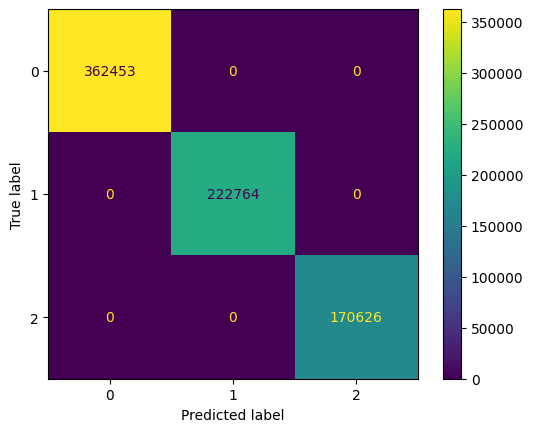

In [47]:
# plot_confusion_matrix
dispH = ConfusionMatrixDisplay.from_estimator(
        xgb,
        X_test,
        y_test,
    )
dispH.confusion_matrix

In [48]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    362453
           1       1.00      1.00      1.00    222764
           2       1.00      1.00      1.00    170626

    accuracy                           1.00    755843
   macro avg       1.00      1.00      1.00    755843
weighted avg       1.00      1.00      1.00    755843



**Truncated**

array([[362453,      0,      0],
       [     0, 222764,      0],
       [     0,      0, 170626]])

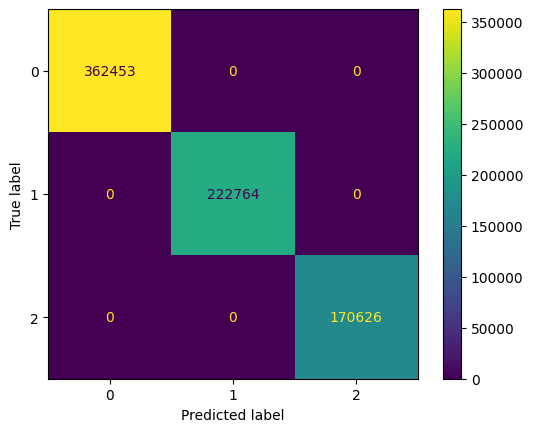

In [49]:
# plot_confusion_matrix
dispH = ConfusionMatrixDisplay.from_estimator(
        xgb_tr,
        Xtr_test,
        ytr_test,
    )
dispH.confusion_matrix

In [50]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    362453
           1       1.00      1.00      1.00    222764
           2       1.00      1.00      1.00    170626

    accuracy                           1.00    755843
   macro avg       1.00      1.00      1.00    755843
weighted avg       1.00      1.00      1.00    755843

